<a href="https://colab.research.google.com/github/AbdulmalikGiwa/Insurance-Claim-Prediction/blob/master/Insuranceclaim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

A predictive model to determine if a building will have an insurance claim during a certain period or not. A few features were provided which will be explored to select the important and best feaures to build the model after analysis is done

In [1]:
#importing all libraries needed
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import  LabelEncoder

Using TensorFlow backend.


In [2]:
#importing train set
train = pd.read_csv('/content/train_data.csv')
test = pd.read_csv('/content/test_data.csv')
#Creating an entire column to fill train and test locations with tags to make seperating them easier later on
train['col'] = 'train' 
test['col'] = 'test'
#new dataframe combining train and test
total = pd.concat([train,test], ignore_index=True) 
print(total.shape, train.shape, test.shape)

(10229, 15) (7160, 15) (3069, 14)


# Exploratory Analysis and Data Wrangling

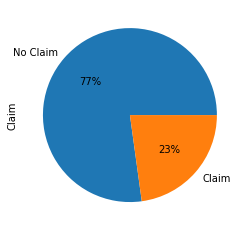

In [3]:
train['Claim'].value_counts().plot(kind='pie', labels=['No Claim','Claim'],autopct='%1.0f%%')

From this pie chart, it can be seen that 77% of Customers from the train data did not make an insurance claim during the specified period. The most popular case here is of No claim. The main aim of this project is to predict future Claim or No claim situation to give the company a foresight as to which customers will make a claim or not 

In [4]:
total.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,col
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0.0,train
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0.0,train
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0.0,train
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0.0,train
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0.0,train


In [5]:
total.isna().sum() #checking for missing values in the dataset

Customer Id              0
YearOfObservation        0
Insured_Period           0
Residential              0
Building_Painted         0
Building_Fenced          0
Garden                  11
Settlement               0
Building Dimension     119
Building_Type            0
Date_of_Occupancy     1236
NumberOfWindows          0
Geo_Code               115
Claim                 3069
col                      0
dtype: int64

In [6]:
total.nunique()

Customer Id           10229
YearOfObservation         5
Insured_Period          467
Residential               2
Building_Painted          2
Building_Fenced           2
Garden                    2
Settlement                2
Building Dimension     2463
Building_Type             4
Date_of_Occupancy       139
NumberOfWindows          11
Geo_Code               1525
Claim                     2
col                       2
dtype: int64

In [7]:
total.describe() #brief statistics of the data

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,10229.000000,10229.000000,10229.000000,10110.000000,10229.000000,8993.000000,7160.000000
mean,2013.646789,0.913672,0.281064,1818.152918,2.238049,1965.061715,0.228212
std,1.380660,0.233806,0.449540,2272.111284,0.961589,33.548619,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,1.000000,0.000000,500.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1002.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2190.000000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,30745.000000,4.000000,2016.000000,1.000000


From these figures and tables above, there are a few noticeable things to take note of :

*   The minimum value in the Building Dimension is 1m^2 which is completely impossible, no habitable building can be 1m^2
*   The minimum date of occupancy is 1545, this is a possible but extremely unlikely scenario. Asides from looking like a highly unusual figure, it deviates greatly from the mean.


*   The NumberofWindows has missing values that can be seen from the first five rows, and these values do not reflect as Nan
*   List item





## Creating Useful Tools

This section consists of a class 'DataCleaner' in which I have defined two very useful methods that will be used for data cleaning processes subsequently in this analysis. The method 'handle_missing_categorical' will be used to replace NaN values in columns of categorical data while the 'handle_missing_continous' will be used for replacing NaN values in columns of continuous data. There are two different methods due to the few differences that exist while fitting models to predict continuous and categorical variables. Both methods take in data-related arguments and a final argument which is an instance variable of the selected ML algorithm to be used in predicting the missing values.

The other tools are the 'tweaks' function and 'best_neighbors' function. The tweaks function applies LabelEncoder and get_dummies on selected columns, LabelEncoder converts column labels of categorical data into numeric data to enable the ML algorithms fit the data, get_dummies converts categorical variables into indicator variables and creates new columns, it is mostly used when there are more than two categories in the column.'best_neighbors' helps to select the best n_neigbors for a KNeighborsClassifier

In [0]:
#LabelEncoder encodes categorical variablees with integers, ML algorithms cannot work with string values


le = LabelEncoder() 
#function to get dummies and encode
def tweaks(table,cols) : 

  table = pd.get_dummies(table, columns=['Building_Type'])
 
  #cols.append(extra)
  for i in cols :
    table[i] = le.fit_transform(table[i])

  return table 








In [0]:
# dummy variables creates  new columns for categorical variables and encodes with 1 and 0

class DataCleaner :

  def handle_missing_categorical(self,dum_gen,col_in_view,col_not_used,model,og_frame,cols):
    #This function will help to sort missing values in columns and return a new dataframe with missing values in
    #the selected column(columns of categorical data) replaced by values predicted by a chosen ML algorithm
    in_ytrain = dum_gen.loc[dum_gen[col_in_view].notnull(), col_in_view]
    in_xtrain = dum_gen.loc[dum_gen[col_in_view].notnull()]
    in_xtrain = in_xtrain.drop(col_not_used, axis=1)
    in_xtest = dum_gen.loc[dum_gen[col_in_view].isnull(), in_xtrain.columns]

    #in_ytrain = le.fit_transform(in_ytrain)
    in_xtrain= preprocessing.StandardScaler().fit(in_xtrain).transform(in_xtrain) #normalizing data
    in_xtest= preprocessing.StandardScaler().fit(in_xtest).transform(in_xtest)

    model.fit(in_xtrain, in_ytrain) #fit the model

    pred = model.predict(in_xtest)
    pred= pd.DataFrame(pred)

    samp = dum_gen.loc[dum_gen[col_in_view].isnull()]
    samp2 = samp[['Customer Id']].copy()
    samp2.reset_index(drop=True, inplace=True)
    pred.reset_index(drop=True,inplace=True)

    fixed = pd.concat([samp2, pred], axis=1)
    fixed.columns = ['Customer Id', col_in_view]

    og = og_frame.loc[og_frame[col_in_view].isnull()]
    og.reset_index(drop=True, inplace=True)
    
    merged = pd.merge(og[cols], fixed)
    

    og_copy = og_frame.drop(og_frame.loc[og_frame[col_in_view].isnull()].index)
    
    final_table = pd.concat([og_copy,merged])

    return final_table


  def handle_missing_continuous(self,dum_gen,col_in_view,col_not_used,model,og_frame,cols):
    #This function will help to sort missing values in columns and return a new dataframe with missing values in
    #the selected column(column of continuous data) replaced by values predicted by a chosen ML algorithm
    in_ytrain = dum_gen.loc[dum_gen[col_in_view].notnull(), col_in_view]
    in_xtrain = dum_gen.loc[dum_gen[col_in_view].notnull()]
    in_xtrain = in_xtrain.drop(col_not_used, axis=1)
    in_xtest = dum_gen.loc[dum_gen[col_in_view].isnull(), in_xtrain.columns]

    #in_ytrain = le.fit_transform(in_ytrain)
  

    model.fit(in_xtrain, in_ytrain) #fit the model

    pred = model.predict(in_xtest)
    pred= pd.DataFrame(pred) #missing values predicted

    samp = dum_gen.loc[dum_gen[col_in_view].isnull()]
    samp2 = samp[['Customer Id']].copy()
    samp2.reset_index(drop=True,inplace=True)
    pred.reset_index(drop=True,inplace=True)

    fixed = pd.concat([samp2, pred], axis=1)
    fixed.columns = ['Customer Id', col_in_view] #customerId of missing values

    
    og = og_frame.loc[og_frame[col_in_view].isnull()]
    og.reset_index(drop=True, inplace=True)
    
    merged = pd.merge(og[cols], fixed)
    

    og_copy = og_frame.drop(og_frame.loc[og_frame[col_in_view].isnull()].index)
    
    final_table = pd.concat([og_copy,merged])

    return final_table






 

In [0]:
#This is to select the best no of neighbors for the KNN classifier
def best_neighbors(x,y,samp_num=10) :
  Ks = samp_num
  jacc= np.zeros((Ks-1))

  for n in range(1,Ks) :
      neigh = KNeighborsClassifier(n_neighbors=n).fit(x,y)
      
      jacc[n-1] = neigh.score(x,y)
  return jacc

## Missing values in 'Garden' column


There are four(4) columns with missing values, In this section I will deal with the values mising in the column of buildings with/without a garden. A K-Nearest Neighbor classifier will be used to predict the missing values. The missing values will then be filled by the predicted values and all of this is already made easier by a predefined method. 
The column is a categorical variable one since there are just two options, and hence the use of the 'handle_missing_categorical'

In [0]:
colnot = ['Geo_Code', 'Claim', 'col', 'NumberOfWindows', 'Date_of_Occupancy', 'Customer Id',
                        'Building Dimension','Garden']

In [0]:
samp = total.copy()
col_g = ['Building_Painted', 'Building_Fenced', 'Settlement']
samp1= tweaks(samp,col_g)

In [13]:
all_colg= ['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
  'Building_Painted', 'Building_Fenced','Settlement',
  'Building Dimension', 'Date_of_Occupancy', 'NumberOfWindows',
  'Geo_Code', 'Claim', 'col', 'Building_Type']
sampneigh = KNeighborsClassifier(n_neighbors=7)
clean1 = DataCleaner()
clean1 = clean1.handle_missing_categorical(samp1,'Garden',colnot,sampneigh,samp,all_colg)
print(clean1.shape)

(10229, 15)


In [14]:
clean1.isna().sum()

Customer Id              0
YearOfObservation        0
Insured_Period           0
Residential              0
Building_Painted         0
Building_Fenced          0
Garden                   0
Settlement               0
Building Dimension     119
Building_Type            0
Date_of_Occupancy     1236
NumberOfWindows          0
Geo_Code               115
Claim                 3069
col                      0
dtype: int64

Column 'Garden' has been successfully handled

## Missing values in 'Building Dimension'

As noticed earlier on that the smallest value in building dimension column is 1m^2 which should be impossible, no building is possibly that small, I'll have to do a little bit of research to understand the smallest possible dimension for a building then use this to restructure the column because the problem in this column exceeds just NaN values

In [0]:

clean1.loc[clean1['Building Dimension']<30, 'Building Dimension']= np.nan #replaces all values less than 30 with Nan


All dimensions lesser than 30m^2 are considered as missing  values and this is because from some research I did through sources online, the minimum dimension for a building is expected to fall within the range of 30m^2 to 37m^2, for this reason I'll take 30 as the minimum acceptable dimension therefore every row with values of Building Dimension being lesser than 30  will be replaced by NaN. After sorting the irregularity in the dimension, A Linear Regression algorithm will be used to predict all the unknown values 

In [0]:
colnotbd = ['Geo_Code', 'Claim', 'col', 'NumberOfWindows', 'Date_of_Occupancy', 'Customer Id',
                        'Building Dimension'] #columns to  be dropped
all_colbd= ['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
                'Building_Painted', 'Building_Fenced','Settlement',
                'Garden', 'Date_of_Occupancy', 'NumberOfWindows',
                'Geo_Code', 'Claim', 'col', 'Building_Type']#columns used in merge

In [17]:
lr = LinearRegression()
col_bd = ['Building_Painted', 'Building_Fenced', 'Settlement','Garden']
samp2= tweaks(clean1,col_bd)
sampp=  clean1.copy()
clean2 = DataCleaner()
clean2 = clean2.handle_missing_continuous(samp2,'Building Dimension',colnotbd,lr,sampp,all_colbd)
print(clean2.shape)

(10229, 15)


In [18]:
clean2.isna().sum()

Customer Id              0
YearOfObservation        0
Insured_Period           0
Residential              0
Building_Painted         0
Building_Fenced          0
Garden                   0
Settlement               0
Building Dimension       0
Building_Type            0
Date_of_Occupancy     1236
NumberOfWindows          0
Geo_Code               115
Claim                 3069
col                      0
dtype: int64

In [19]:
clean2.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,8993.000000,7160.000000
mean,2013.646789,0.913672,0.281064,1821.141656,2.238049,1965.061715,0.228212
std,1.380660,0.233806,0.449540,2256.806453,0.961589,33.548619,0.419709
min,2012.000000,0.000000,0.000000,30.000000,1.000000,1545.000000,0.000000
25%,2012.000000,1.000000,0.000000,516.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1045.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2169.000000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,30745.000000,4.000000,2016.000000,1.000000


## 'Date_of_Occupancy' Column

This feture will be treated as categorical data in this case, from the exploratory analysis done previously, it was seen that this feature has just 139 unique values. Treating this as continuous data will not be appropriate in this case

In [20]:
clean2.loc[clean2['Date_of_Occupancy']<=1800].head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,col
4,H5053,2014,1.000000,0,V,N,O,R,680.0,1,1800.0,3,1053,0.0,train
12,H15676,2013,1.000000,0,V,N,O,R,842.0,1,1550.0,4,1305,0.0,train
21,H16563,2016,0.997268,0,V,N,O,R,2400.0,1,1700.0,3,2408,0.0,train
34,H16387,2012,1.000000,0,V,N,O,R,480.0,2,1800.0,4,4088,0.0,train
187,H19770,2015,0.260274,0,V,N,O,R,100.0,4,1800.0,3,6030,0.0,train


There are a number of unusual values in this column, with years ranging from mid 1500s to early 1700s and these values do not seem normal considering the fact that even the first storey building in Nigeria was built in 1845, any building that old and still being inhabited or insured either has some historic origin or has been completely renovated or rebuilt, This column is populated with a lot of these values and what makes the most sense at this point is to drop the entire column, although if the model produces a poor performance after then there may be need to carry out proper investigation in this column in order to understand why exactly these values are missing and decide the best step to take. The date of occupancy is an important feature since older buildings are most likely to have a reason to make a claim but this feature is of no use if there are so many errors that would  be difficult to correct.

In [0]:
clean2.drop(['Date_of_Occupancy'], axis=1, inplace=True) #dropping column

## 'NumberOfWindows' column

In [22]:
clean2['NumberOfWindows'].value_counts()

   .    5791
4       1133
3       1071
5        790
2        433
6        376
7        265
8        142
1         91
>=10      78
9         59
Name: NumberOfWindows, dtype: int64

There are multiple rows with values of '  .' which are just missing values in short, it can be seen that the values missing are more than 50% of the entire dataset and the best thing to do here is to drop the entire column

In [0]:
clean2.drop(['NumberOfWindows'], axis=1,inplace=True)

In [24]:
clean2.nunique()

Customer Id           10229
YearOfObservation         5
Insured_Period          467
Residential               2
Building_Painted          2
Building_Fenced           2
Garden                    2
Settlement                2
Building Dimension     2469
Building_Type             4
Geo_Code               1525
Claim                     2
col                       2
dtype: int64

## GeoCode column

In [25]:
clean2['Geo_Code'].value_counts()

6088     238
6083     226
13206    166
33063    162
13205    133
        ... 
6059       1
84087      1
76613      1
17093      1
21166      1
Name: Geo_Code, Length: 1525, dtype: int64

There are 115 missing values in this column and the most likely reason fo geocode value to be missing(in a small number like that) would be because there was some error in collection of geo_code for certain errors, fromt the value counts done above, it can be seen that there are geocodes common in multiple rows with the highest even being over double of the 115 missing, for this reason what I'll be doing here is to represent the missing values as an entirely different category 

In [26]:
clean2.loc[clean2['Geo_Code']=='1234'] #checking for random number available

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Geo_Code,Claim,col


In [0]:
clean2['Geo_Code'].replace({np.nan:'1234'},inplace=True)

## Splitting back into train/test + some final touches

In [0]:
def tweaks2(table) : 

  table = pd.get_dummies(table, columns=['Building_Type','Geo_Code'])
 
  cols = ['Residential','Building_Painted', 'Building_Fenced', 'Garden', 'Settlement']
  for i in cols :
    table[i] = le.fit_transform(table[i])

  return table 

In [0]:
clean2 = tweaks2(clean2)

In [30]:
clean2.isna().sum()

Customer Id          0
YearOfObservation    0
Insured_Period       0
Residential          0
Building_Painted     0
                    ..
Geo_Code_95563       0
Geo_Code_95582       0
Geo_Code_95585       0
Geo_Code_95598       0
Geo_Code_95607       0
Length: 1541, dtype: int64

In [31]:
clean2.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Claim,col,Building_Type_1,Building_Type_2,Building_Type_3,Building_Type_4,Geo_Code_10033,Geo_Code_10081,Geo_Code_10297,Geo_Code_10333,Geo_Code_10343,Geo_Code_10362,Geo_Code_10387,Geo_Code_1053,Geo_Code_11069,Geo_Code_11076,Geo_Code_11170,Geo_Code_11202,Geo_Code_11262,Geo_Code_11266,Geo_Code_1143,Geo_Code_11441,Geo_Code_1160,Geo_Code_1173,Geo_Code_11910,Geo_Code_12052,Geo_Code_12084,Geo_Code_12096,Geo_Code_12145,Geo_Code_12174,Geo_Code_12176,...,Geo_Code_94074,Geo_Code_94076,Geo_Code_94078,Geo_Code_94079,Geo_Code_94080,Geo_Code_94081,Geo_Code_95014,Geo_Code_95018,Geo_Code_95042,Geo_Code_95051,Geo_Code_95052,Geo_Code_95060,Geo_Code_95063,Geo_Code_95127,Geo_Code_95176,Geo_Code_95183,Geo_Code_95197,Geo_Code_95199,Geo_Code_95203,Geo_Code_95205,Geo_Code_95210,Geo_Code_95219,Geo_Code_95252,Geo_Code_95280,Geo_Code_95288,Geo_Code_95306,Geo_Code_95313,Geo_Code_95394,Geo_Code_95424,Geo_Code_95426,Geo_Code_95428,Geo_Code_95488,Geo_Code_95500,Geo_Code_95539,Geo_Code_95555,Geo_Code_95563,Geo_Code_95582,Geo_Code_95585,Geo_Code_95598,Geo_Code_95607
0,H14663,2013,1.0,0,0,1,1,1,290.0,0.0,train,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H2037,2015,1.0,0,1,0,0,0,490.0,0.0,train,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,H3802,2014,1.0,0,0,1,1,1,595.0,0.0,train,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,H3834,2013,1.0,0,1,1,1,1,2840.0,0.0,train,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,H5053,2014,1.0,0,1,0,0,0,680.0,0.0,train,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The data cleaning is complete so now the next thing would be to split the train and test sets back into train and test, a column was created at the beginning of this project to mark the rows into train and test, this column will be used here to seperate them back

In [0]:
train = clean2.loc[clean2['col']=='train'].reset_index(drop=True)
test = clean2.loc[clean2['col']=='test'].reset_index(drop=True)

test.drop(['Claim','col'], axis=1, inplace=True)
train.drop(['col'], axis=1, inplace=True)

In [33]:
train.isna().sum() 

Customer Id          0
YearOfObservation    0
Insured_Period       0
Residential          0
Building_Painted     0
                    ..
Geo_Code_95563       0
Geo_Code_95582       0
Geo_Code_95585       0
Geo_Code_95598       0
Geo_Code_95607       0
Length: 1540, dtype: int64

Train set is clean :)

In [34]:
test.isna().sum()

Customer Id          0
YearOfObservation    0
Insured_Period       0
Residential          0
Building_Painted     0
                    ..
Geo_Code_95563       0
Geo_Code_95582       0
Geo_Code_95585       0
Geo_Code_95598       0
Geo_Code_95607       0
Length: 1539, dtype: int64

Test is clean too :) 

# Model Development